## CIFAR10 Sample

CIFAR10 sample with preparing large datasets

- CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
- original sample: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

This sample demonstrates:

- preparing large dataset
- use `ImageDataGenerator` to load dataset
- predict using url image

### Data Prep

reference source: https://cntk.ai/pythondocs/CNTK_201A_CIFAR-10_DataLoader.html

In [1]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)

from PIL import Image
import numpy as np
import pickle as cp
import os
import shutil
import sys

In [2]:
imgSize = 32

__Note__: download/unzip/untar `https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz` to `../datasets` directory before run below code

In [3]:
def saveImage(fname, data, pad, **key_parms):
    # data in CIFAR-10 dataset is in CHW format.
    pixData = data.reshape((3, imgSize, imgSize))
    
    if pad > 0:
        pixData = np.pad(pixData, ((0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=128)

    img = Image.new('RGB', (imgSize + 2 * pad, imgSize + 2 * pad))
    pixels = img.load()
    
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            pixels[x, y] = (pixData[0][y][x], pixData[1][y][x], pixData[2][y][x])
    img.save(fname)
    
def saveTrainImages(datapath, foldername):
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    data = {}

    for ifile in range(1, 6):
        print('... reading file `data_batch_%d`' % ifile)
        with open(os.path.join(datapath, 'data_batch_' + str(ifile)), 'rb') as f:
            if sys.version_info[0] < 3:
                data = cp.load(f)
            else:
                data = cp.load(f, encoding='latin1')
                
            for i in range(10000):
                fdir = os.path.join(os.path.abspath(foldername), ('%d') % (data['labels'][i]))
                fname = os.path.join(fdir, ('%d-%05d.png' % (data['labels'][i], i + (ifile - 1) * 10000)))
                saveImage(fname, data['data'][i, :], 0)


def saveTestImages(datapath, foldername):
    if not os.path.exists(foldername):
        os.makedirs(foldername)

    with open(os.path.join(datapath, 'test_batch'), 'rb') as f:
        if sys.version_info[0] < 3:
            data = cp.load(f)
        else:
            data = cp.load(f, encoding='latin1')
        for i in range(10000):
            fdir = os.path.join(os.path.abspath(foldername), ('%d') % (data['labels'][i]))
            fname = os.path.join(fdir, ('%d-%05d.png' % (data['labels'][i], i)))
            saveImage(fname, data['data'][i, :], 0)

In [4]:
# create label folders
datapath = '../datasets/cifar-10-batches-py'
trainpath = os.path.join(os.path.abspath(datapath), 'train')
testpath = os.path.join(os.path.abspath(datapath), 'test')

# created labeled folders
for label in range(0, 10):
    directory = os.path.join(trainpath, '%d' % label)
    if not os.path.exists(directory):
        os.makedirs(directory)

for label in range(0, 10):
    directory = os.path.join(testpath, '%d' % label)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
# create png images from original datasets
print ('Converting train data to png images...')
saveTrainImages(datapath, os.path.join(datapath, trainpath))
print ('Done.')
print ('Converting test data to png images...')
saveTestImages(datapath, os.path.join(datapath, testpath))
print ('Done.')

Converting train data to png images...
... reading file `data_batch_1`
... reading file `data_batch_2`
... reading file `data_batch_3`
... reading file `data_batch_4`
... reading file `data_batch_5`
Done.
Converting test data to png images...
Done.


### CIFAR10 training

reference source: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

In [6]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import os
import matplotlib.pyplot as plt

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
batch_size = 32
num_classes = 10
epochs = 100
#data_augmentation = True
#num_predictions = 20
save_dir = os.path.abspath('../models')
model_name = 'sample_cifar10_model.h5'

In [8]:
# read dataset from directory
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    trainpath,
    target_size=(imgSize, imgSize),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    testpath,
    target_size=(imgSize, imgSize),
    batch_size=batch_size,
    class_mode='categorical')

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [9]:
nb_train_samples = 50000
nb_validation_samples = 10000

if K.image_data_format() == 'channels_first':
    input_shape = (3, imgSize, imgSize)
else:
    input_shape = (imgSize, imgSize, 3)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
1562/1562 [==============================] - 25s 16ms/step - loss: 1.8047 - acc: 0.3396 - val_loss: 1.5255 - val_acc: 0.4468
Epoch 2/100
1562/1562 [==============================] - 20s 13ms/step - loss: 1.5170 - acc: 0.4484 - val_loss: 1.3558 - val_acc: 0.5153
Epoch 3/100
1562/1562 [==============================] - 20s 13ms/step - loss: 1.3871 - acc: 0.5004 - val_loss: 1.3051 - val_acc: 0.5383
Epoch 4/100
1562/1562 [==============================] - 20s 13ms/step - loss: 1.2969 - acc: 0.5383 - val_loss: 1.1772 - val_acc: 0.5882
Epoch 5/100
1562/1562 [==============================] - 20s 13ms/step - loss: 1.2269 - acc: 0.5637 - val_loss: 1.1346 - val_acc: 0.5977
Epoch 6/100
1562/1562 [==============================] - 20s 13ms/step - loss: 1.1631 - acc: 0.5896 - val_loss: 1.0603 - val_acc: 0.6259
Epoch 7/100
1562/1562 [==============================] - 20s 13ms/step - loss: 1.1099 - acc: 0.6088 - val_loss: 1.0094 - val_acc: 0.6476
Epoch 8/100
1562/1562 [==================

1562/1562 [==============================] - 20s 13ms/step - loss: 0.6699 - acc: 0.7765 - val_loss: 0.7523 - val_acc: 0.7798
Epoch 60/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.6760 - acc: 0.7745 - val_loss: 0.6351 - val_acc: 0.7898
Epoch 61/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.6691 - acc: 0.7783 - val_loss: 0.6429 - val_acc: 0.7874
Epoch 62/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.6631 - acc: 0.7781 - val_loss: 0.6902 - val_acc: 0.7841
Epoch 63/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.6643 - acc: 0.7788 - val_loss: 0.6216 - val_acc: 0.7924
Epoch 64/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.6652 - acc: 0.7802 - val_loss: 0.6616 - val_acc: 0.7933
Epoch 65/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.6665 - acc: 0.7771 - val_loss: 0.6346 - val_acc: 0.7953
Epoch 66/100
1562/1562 [=======================

In [12]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/iljoong/models/sample_cifar10_model.h5 


In [13]:
# Load model
model_path = os.path.join(save_dir, model_name)

model = keras.models.load_model(model_path)

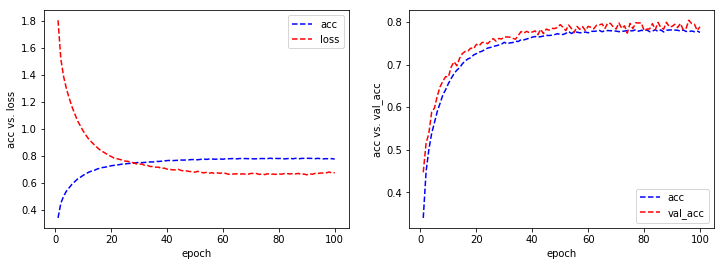

In [14]:
# Get training and test loss histories
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(loss) + 1)

# Visualize loss history
fig=plt.figure(figsize=(12, 4))
plt.figure(1)

fig.add_subplot(121)
plt.plot(epoch_count, acc, 'b--')
plt.plot(epoch_count, loss, 'r--')
plt.legend(['acc', 'loss'])
plt.xlabel('epoch')
plt.ylabel('acc vs. loss')

fig.add_subplot(122)
plt.plot(epoch_count, acc, 'b--')
plt.plot(epoch_count, val_acc, 'r--')
plt.legend(['acc', 'val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc vs. val_acc')

plt.show()

### Predict

test url or get url from search

In [15]:
import requests
from PIL import Image
import cv2
from keras.preprocessing import image
from io import BytesIO

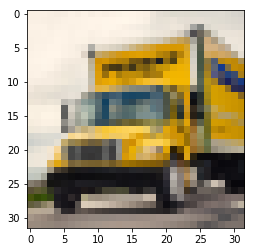

In [16]:
#test_url = "https://boygeniusreport.files.wordpress.com/2017/01/cat.jpg"
test_url = "https://www.pensketruckrental.com/img/hero/hero_trucks_22.jpg"

r = requests.get(test_url)

img = Image.open(BytesIO(r.content))
rsimg = cv2.resize(np.array(img), (32, 32), interpolation = cv2.INTER_AREA)
plt.imshow(rsimg)

In [17]:
img = Image.fromarray(rsimg)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.
classes = model.predict(x)

In [18]:
print(classes, np.argmax(classes))

l = np.argmax(classes)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(labels[l])

[[5.5321667e-08 6.8723911e-04 1.0592832e-13 4.5877880e-12 9.1466650e-15
  5.7555109e-14 5.7450507e-13 2.9905965e-12 1.2686054e-07 9.9931264e-01]] 9
truck
